# Experiment: shape parameter $\beta$ on cluster coefficient

### Definition

Global cluster coefficient is an index on  hypergraph $H$'s clustering pattern, denoted by $C(H)$ 
$$
\begin{aligned}
     C(H) = \frac{1}{|V|} \sum\limits_{v \in V} c(v) \\
\end{aligned}
$$
where $V$ is vertex set of hypergraph/graph and $c(v) = \frac{1}{|N(v)|} \sum\limits_{u \in N(v)} \rho(v,u)$ is node cluster coefficient, $N(v)$ is neighbourhood of node $v$ and $\rho(v, u) = \frac{|E(v) \bigcap E(u)|}{|E(v) \bigcup  E(u)|}$.


- large $C(H)$ => $H$ is well-connected;
- small $C(H)$ =>  $H$ is isolated.


### Idea

Model with different $\beta$ shows different clustering tendency:

- small $\beta$ => $H$ is well-connected;
- large $\beta$ =>  $H$ is isolated.

We run simulation to verify the claim.



### Steps

- Hand-made latent features that one cluster at center while a number of other clusters are roughly located at a circle.

- Simulate $k$-uniform hypergraphs from the coauthorship model with $\beta \in [0.05, 1, 50]$

- Compute cluster coefficient against number of hyperedges generated.

### 0. Load libraies and helpers

In [1]:
suppressPackageStartupMessages({
    library(Rcpp)
    library(geometry) # calculate convex hull volume
    library(MASS) # stats  
    library(mnormt) # generate mulvariate gaussian in porposal
    library(ggplot2) 
    library(igraph) # graph alg and visualization
    library(CVXR) # optimization used in warm start in mcem
    library(viridis)  # color palettes
    library(gridExtra) # ggplot helper
    library(bezier) # add arrow among ggplots
})

sourceCpp('../code/helper_comb.cpp') # combinatorial functions
source('../code/helper_general.R') # general helpers
source('../code/helper_cluster_coef.R') # helpers for the experiment


### 1. Set up cluster features

In [2]:
num.clust.demo = 7 # one central cluster and the rest are clusters along circle
size.clust.demo = 4 # num. of nodes in each cluster
radius.demo = 10
clust.sd = radius.demo/10 # radius of each cluster 
p.demo = 2
edge.demo = c()

# Create clusters feature mats and save in feat.all.demo
feat.all.demo = get.gaussian.featmat(nrow = size.clust.demo, ncol = p.demo, mean = c(0,0), var1 = clust.sd^2, cov12 = 0)
for (which.clust in 1:(num.clust.demo-1)){
    angle = (which.clust-1)/(num.clust.demo-1) *(2*pi)
    clust.mean = c(radius.demo * cos(angle), radius.demo*sin(angle))
    feat.clust = get.gaussian.featmat(nrow = size.clust.demo , ncol = p.demo,
                                                mean = clust.mean, var1 = clust.sd^2, cov12 = 0)
    feat.all.demo = rbind(feat.all.demo, feat.clust)
}


### 2. Calculate cluster coefficient

- Simulate $k$-uniform hypergraphs using $\beta = [.1, .5, 1]$
- Compute clust. coef. respectively

In [3]:
set.seed(123)
k.demo = 3                                               # ------------ k ---------#
n.demo = dim(feat.all.demo)[1]
subset.mat.demo = find_subset(n.demo , k.demo)
shape.vec = c('gamma','pareto','gaussian', 'window')
save.path = "./output/"
num.sample.vec.demo = seq(10,50,10)                    # ---------- experiment num of sample --------- #    

which.shape.demo = shape.vec[1]                        # ------------ shape type ---------#
hg.edge.list = list()
true.beta.vec.demo = c(0.05, 0.5 , 50)                   #----------------shape parameters to plot--------#
cc.hg = matrix(0, len(true.beta.vec.demo), len(num.sample.vec.demo))
for (which.beta in 1:len(true.beta.vec.demo)){
    true.beta = true.beta.vec.demo[which.beta]
    for (which.sample in 1:len(num.sample.vec.demo)) {
        num.sample = num.sample.vec.demo[which.sample]
        sim.data =sample.from.shape.cvxhull(n = n.demo  , k = k.demo,
                                        subset.mat = subset.mat.demo,
                                        feat.mat = feat.all.demo,
                                        num.sample = num.sample,
                                        which.shape = which.shape.demo,
                                        param.vec = c(1, true.beta), # gamma
                                        #param.vec = c(true.beta.demo,1), # gauss
                                        if.save.sample = F, save.path = save.path )
        edge.demo = sim.data$edge.sampled
        cc.hg[which.beta, which.sample] =  clust.coef.hg(n.demo, edge.demo)
        print(paste0('gamma: beta = ', true.beta, ', num.sample = ' , num.sample.vec.demo[which.sample],', clus coef = ',cc.hg[which.beta, which.sample], ' is done'))
    }
    hg.edge.list[[which.beta]] = edge.demo
    cc.hg.gamma = cc.hg
    sample.gamma.lst = hg.edge.list
}


[1] "gamma: beta = 0.05, num.sample = 10, clus coef = 0.7 is done"
[1] "gamma: beta = 0.05, num.sample = 20, clus coef = 0.967383013811585 is done"
[1] "gamma: beta = 0.05, num.sample = 30, clus coef = 0.956984681984682 is done"
[1] "gamma: beta = 0.05, num.sample = 40, clus coef = 1.0108768142271 is done"
[1] "gamma: beta = 0.05, num.sample = 50, clus coef = 0.959019691272518 is done"
[1] "gamma: beta = 0.5, num.sample = 10, clus coef = 0.942857142857143 is done"
[1] "gamma: beta = 0.5, num.sample = 20, clus coef = 1.26173469387755 is done"
[1] "gamma: beta = 0.5, num.sample = 30, clus coef = 1.6984410430839 is done"
[1] "gamma: beta = 0.5, num.sample = 40, clus coef = 0.983375086631389 is done"
[1] "gamma: beta = 0.5, num.sample = 50, clus coef = 1.78573337260312 is done"
[1] "gamma: beta = 50, num.sample = 10, clus coef = 2.35714285714286 is done"
[1] "gamma: beta = 50, num.sample = 20, clus coef = 5.19047619047619 is done"
[1] "gamma: beta = 50, num.sample = 30, clus coef = 7.43452

### 3. Plot

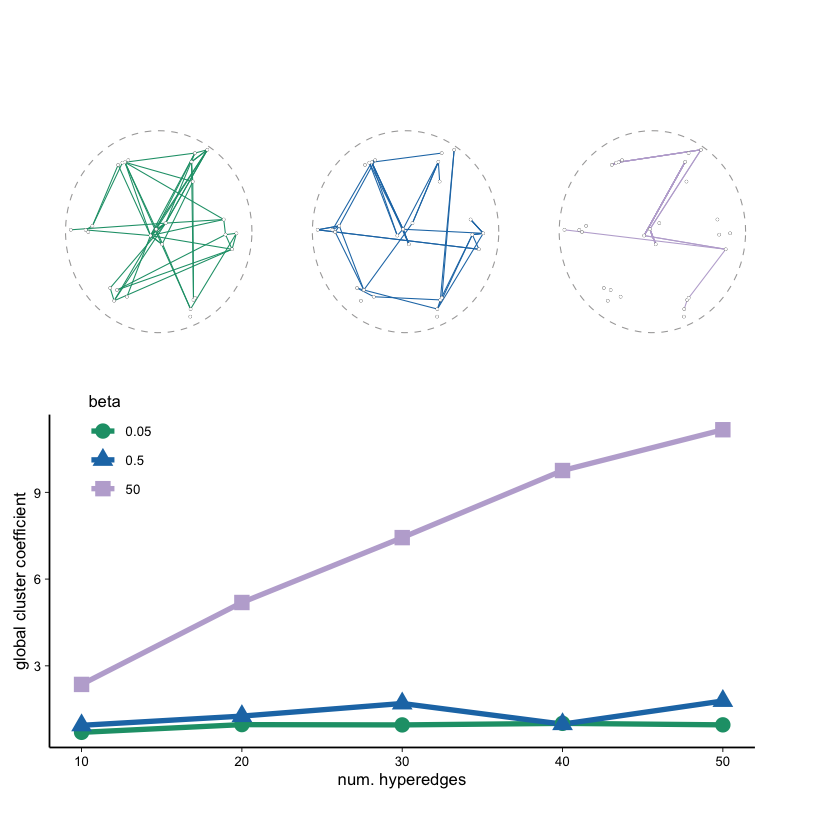

In [4]:
 plot.clust.coef(isShow.plot=TRUE, isSave.plot=FALSE)